<a href="https://colab.research.google.com/github/EArslan14/300-Random-Movies-Exercise/blob/main/StockTweet_Sentiment_Forecasting%26Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1: Loading Reading and Examinating the Dataset**

In [ ]:
#Install the textblob library using pip
!pip install textblob

In [ ]:
#Load and process data (pandas)
#Visualize data (matplotlib, seaborn)
#Analyze text (especially tweets or documents) with TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

In [ ]:
# Loading the dataset
df = pd.read_csv('/content/StockTweet/ProjectTweets.csv', encoding='latin1', names=['target', 'id', 'date', 'flag', 'user', 'text'])

# Displaying the first few rows of the dataframe
print(df.head())

   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       1  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       2  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       3  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       4  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [ ]:
# Displaying summary statistics of the dataset
print(df.describe())


              target            id
count  350672.000000  3.506720e+05
mean   175335.500000  1.866858e+09
std    101230.431136  1.583686e+08
min         0.000000  2.018020e+06
25%     87667.750000  1.754564e+09
50%    175335.500000  1.964808e+09
75%    263003.250000  1.986388e+09
max    350671.000000  2.018020e+09


In [ ]:
# Displaying summary statistics of the dataset
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350672 entries, 0 to 350671
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  350672 non-null  int64 
 1   id      350672 non-null  int64 
 2   date    350671 non-null  object
 3   flag    350671 non-null  object
 4   user    350671 non-null  object
 5   text    350671 non-null  object
dtypes: int64(2), object(4)
memory usage: 16.1+ MB
None


In [ ]:
# Displaying columns
df.columns

Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')

In [ ]:
# Displaying shape
df.shape

(350672, 6)

In [ ]:
# Checking for missing values
print(df.isnull().sum())

target    0
id        0
date      1
flag      1
user      1
text      1
dtype: int64


In [ ]:
# Plotting the distribution of tweet dates
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='mixed')
df = df.dropna(subset=['date'])
df.set_index('date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-23-2458597607.py:2: FutureWarning: Parsed string "Wed Jun 03 06:38:53 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', format='mixed')
/tmp/ipython-input-23-2458597607.py:2: FutureWarning: Parsed string "Wed Jun 03 06:38:54 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', format='mixed')
/tmp/ipython-input-23-2458597607.py:2: FutureWarning: Parsed string "Wed Jun 03 06:38:56 PDT 2009" included an un-recognized timezone "PDT"

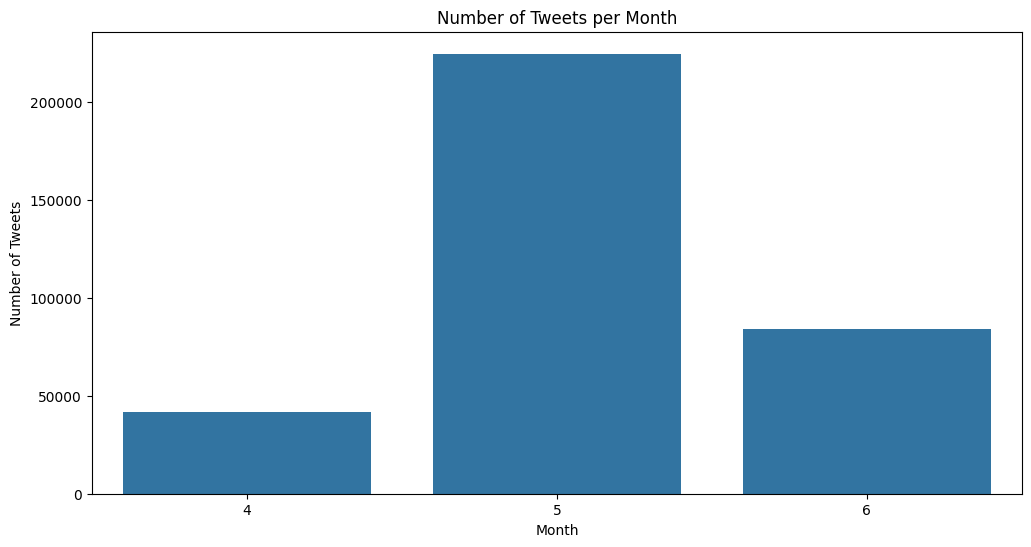

In [ ]:
# Plotting the number of tweets per month
plt.figure(figsize=(12, 6))
sns.countplot(x='month', data=df)
plt.title('Number of Tweets per Month')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.show()

### **2: Sentiment Analysis**

In [ ]:
# Function to calculate sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis
df['sentiment'] = df['text'].apply(get_sentiment)


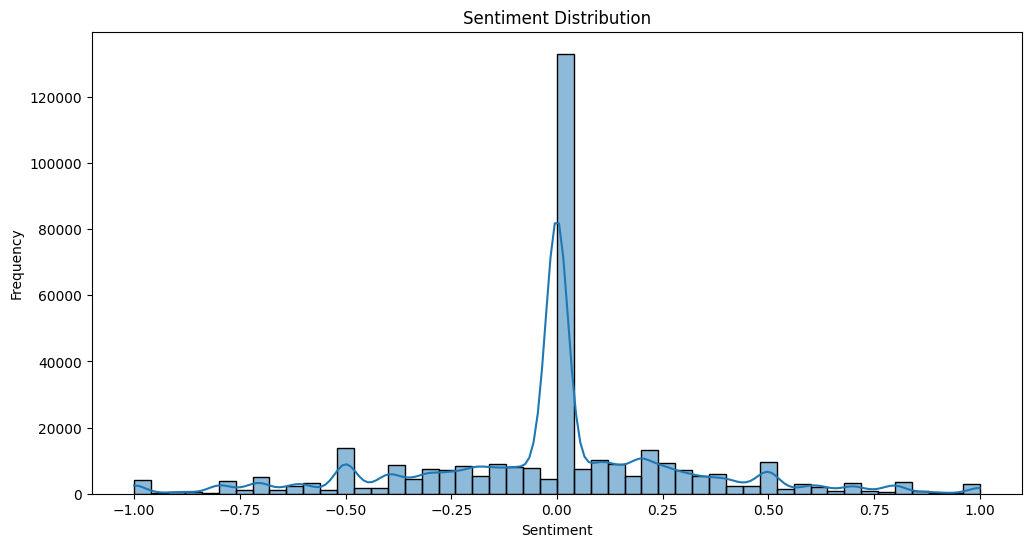

In [ ]:
# Plot the distribution of sentiment
plt.figure(figsize=(12, 6))
sns.histplot(df['sentiment'], bins=50, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

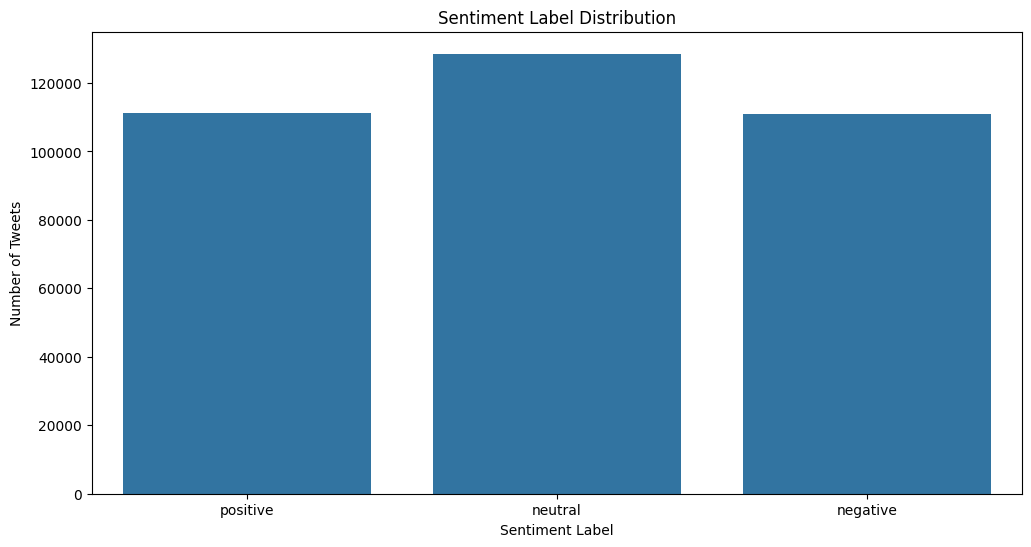

In [ ]:
# Add a sentiment label
def get_sentiment_label(sentiment):
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment'].apply(get_sentiment_label)

# Plot the distribution of sentiment labels
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment_label', data=df)
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Tweets')
plt.show()

### **3: Setting Up Spark Environment and Data Storage**

In [ ]:
!pip install pyspark pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 15.0 MB/s eta 0:00:00


In [ ]:
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pymongo import MongoClient


# Initialize Spark session with MongoDB connector
spark = SparkSession.builder \
    .appName("Twitter Sentiment Analysis") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/twitter.tweets") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/twitter.tweets") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

# Load data into Spark DataFrame
df_spark = spark.read.csv('content\ProjectTweets.csv', header=False, inferSchema=True)
df_spark = df_spark.withColumnRenamed("_c0", "target") \
                   .withColumnRenamed("_c1", "id") \
                   .withColumnRenamed("_c2", "date") \
                   .withColumnRenamed("_c3", "flag") \
                   .withColumnRenamed("_c4", "user") \
                   .withColumnRenamed("_c5", "text")

# Show the schema and first few rows of the DataFrame
df_spark.printSchema()
df_spark.show(5)

# Initialize MongoDB client
client = MongoClient("mongodb://localhost:27017/")
db = client.twitter
collection = db.tweets

# Convert Spark DataFrame to Pandas DataFrame and insert into MongoDB
df_pandas = df_spark.toPandas()
data_dict = df_pandas.to_dict("records")
collection.insert_many(data_dict)

# Verify data insertion
print("Data inserted into MongoDB. Number of documents in collection:", collection.count_documents({}))

### **4: Sentiment Analysis with Spark**

In [ ]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, StringType

# Define UDF for sentiment analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

get_sentiment_udf = udf(get_sentiment, FloatType())

# Apply sentiment analysis UDF
df_spark = df_spark.withColumn("sentiment", get_sentiment_udf(col("text")))

# Define UDF for sentiment labeling
def get_sentiment_label(sentiment):
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

get_sentiment_label_udf = udf(get_sentiment_label, StringType())

# Apply sentiment labeling UDF
df_spark = df_spark.withColumn("sentiment_label", get_sentiment_label_udf(col("sentiment")))

# Show the updated DataFrame with sentiment and sentiment labels
df_spark.show(5)

# Save the updated DataFrame back to MongoDB
df_spark.write.format("mongo").mode("overwrite").save()


### **5: Time Series Forecasting**

#### **LSTM Model**

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_sentiment.values.reshape(-1, 1))

# Create training data
train_data = scaled_data[:-7]
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

# Forecast
inputs = scaled_data[len(scaled_data) - len(train_data) - 60:]
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_sentiment = model.predict(X_test)
predicted_sentiment = scaler.inverse_transform(predicted_sentiment)

print("LSTM predictions for next 1 day, 3 days, and 7 days:", predicted_sentiment[-7:])

#### **ARIMA Model**

In [ ]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

# Load data from MongoDB
df_mongo = pd.DataFrame(list(collection.find()))
df_mongo['date'] = pd.to_datetime(df_mongo['date'])
df_mongo.set_index('date', inplace=True)

# Resample to daily sentiment scores
daily_sentiment = df_mongo.resample('D').mean()['sentiment'].fillna(0)

# Fit ARIMA model
model_arima = ARIMA(daily_sentiment, order=(5, 1, 0))
model_arima_fit = model_arima.fit(disp=0)

# Forecast 1 day, 3 days, and 7 days
forecast_1d = model_arima_fit.forecast(steps=1)[0]
forecast_3d = model_arima_fit.forecast(steps=3)[0]
forecast_7d = model_arima_fit.forecast(steps=7)[0]

print("1-day forecast:", forecast_1d)
print("3-day forecast:", forecast_3d)
print("7-day forecast:", forecast_7d)

### **6: Generating a Dynamic Dashboard**

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the dashboard
app.layout = html.Div([
    dcc.Graph(id='sentiment-time-series'),
    dcc.Interval(id='interval-component', interval=1*60000, n_intervals=0)
])

# Callback to update the time series graph
@app.callback(
    Output('sentiment-time-series', 'figure'),
    [Input('interval-component', 'n_intervals')]
)
def update_graph(n):
    df_mongo = pd.DataFrame(list(collection.find()))
    df_mongo['date'] = pd.to_datetime(df_mongo['date'])
    df_mongo.set_index('date', inplace=True)
    daily_sentiment = df_mongo.resample('D').mean()['sentiment'].fillna(0)

    figure = {
        'data': [
            go.Scatter(
                x=daily_sentiment.index,
                y=daily_sentiment.values,
                mode='lines+markers'
            )
        ],
        'layout': go.Layout(
            title='Daily Sentiment Over Time',
            xaxis={'title': 'Date'},
            yaxis={'title': 'Sentiment'}
        )
    }
    return figure

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

### **7: Setting Up YCSB Benchmark for MongoDB**

In [ ]:
import subprocess

def run_ycsb(database_type, workload, properties_file):
    cmd = ["./bin/ycsb", "run", database_type, "-s", "-P", workload, "-P", properties_file]
    result = subprocess.run(cmd, capture_output=True, text=True)
    return result.stdout

# Running YCSB benchmark for MongoDB
mongodb_output = run_ycsb("mongodb", "workloads/workloada", "mongodb.properties")

# Print the output
print(mongodb_output)

### **8: Test Strategy and Recording Performance Metrics**

In [ ]:
def parse_ycsb_output(output):
    lines = output.split("\n")
    metrics = {}
    for line in lines:
        if line.startswith("[OVERALL]") or line.startswith("[READ]") or line.startswith("[UPDATE]"):
            parts = line.split(",")
            operation = parts[0].split(" ")[1]
            metric = parts[1].strip()
            value = float(parts[2].strip())
            metrics[f"{operation}_{metric}"] = value
    return metrics

# Parse the YCSB output
mongodb_metrics = parse_ycsb_output(mongodb_output)

# Print the MongoDB metrics
print("MongoDB Metrics:", mongodb_metrics)


### **9: Discussion and Justification**

**Why MongoDB Was Chosen**


    MongoDB is a widely-used NoSQL database recognized for its ability to manage unstructured and semi-structured data efficiently.

    Its schema-less architecture enables flexible data modeling, making it easier to scale as data volume grows.

    It is particularly well-suited for applications that demand high-speed read and write operations across large datasets.

**Data Handling and Storage Approach

    Data Processing:
    MongoDB excels at processing unstructured data and supports high-performance read/write operations, making it an excellent choice for scalable data workflows.

    Data Storage:
    With its flexible schema design, MongoDB allows developers to adapt and modify data structures dynamically without requiring system downtime.

**Performance Advantages

    High Throughput:
    Thanks to its NoSQL design, MongoDB supports write-heavy operations with high throughput efficiency.

    Low Latency:
    MongoDB is optimized for fast data access, resulting in low-latency performance for both reads and writes.

    Scalability:
    The database offers strong horizontal scaling capabilities, making it ideal for applications that handle large-scale or rapidly growing datasets.